## 0. Goal
Run UMAP directly on spectrograms from different preprocessing choices. <br>
Then use Hopkins metrics and Silloutte score to quantify clusterability. <br>
Differ from v2: use the same input datasets, but vary the parameters for umap and hdbscan

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8]]
# what syllable to analyze
syl = ['v']
sylStr = ''.join(syl)
# what input dataset to use
input_rn = 'spec_goffinet_nn_256_176'

In [5]:
umap_metric = ['euclidean', 'cosine', 'correlation']
umap_min_dist = [0, 0.05, 0.1]
hdbscan_selection = ['eom', 'leaf']

In [6]:
# other paramteres for UMAP and HDBSCAN
param_umap = {'n_components':2, 'n_neighbors':25}
param_hdbscan = {'min_cluster_size_frac':0.05, 'min_samples': 20}

## 2. UMAP, then HDBSCAN on each dataset

In [7]:
# save metrics in a master dataframe
metrics = pd.DataFrame()

In [13]:
# loop through birds
# for bi in range(0, len(birdIDs)):
for bi in range(1,4):
    bd = birdIDs[bi]
    fd_save = os.path.join(fd_data, bd, 'UMAPonSpec3', sylStr)
    if not os.path.exists(fd_save):
        os.makedirs(fd_save)
    run_names = []
    
    ## load spectrograms and meta info
    fn_spec = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{input_rn}.h5')
    fn_info = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{input_rn}.info.csv')
    with h5py.File(fn_spec, 'r') as f:
        spec_win_all = f['spec_win_all'][:]  #
    info = pd.read_csv(fn_info, index_col=0)
    ## flatten spectrogram
    spec_flat = vae_goffinet.flatten_spectrograms(spec_win_all)
    print(bd, spec_win_all.shape, info.shape, spec_flat.shape)
    
    # loop through different parameters
    for umi in umap_metric:
        for umd in umap_min_dist:
            for hs in hdbscan_selection:
                rn = f'umi{umi}_umd{umd}_hs{hs}'
                run_names.append(rn)
                print(f'Processing for {bd} {rn}...')
                
                ## run UMAP 
                print(param_umap)
                umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=umd, 
                                                              metric=umi, random_state=1118, verbose=True)
                res = umap_model.fit_transform(spec_flat)

                # add UMAP embedding to the dataframe
                embed = info.copy()
                for jj in range(res.shape[1]):
                    embed[f'umap{jj+1}'] = res[:,jj]

                ## plot embedding
                fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
                for si, ss in enumerate(syl):
                    embed_s = embed[embed['label']==ss]
                    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, c=col_list[si])
                    # add syl label
                    ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), ss, fontsize=14)
                ax.set_title(bd, fontsize=14)
                ax.set_xlabel('UMAP axis 1', fontsize=12)
                ax.set_ylabel('UMAP axis 2', fontsize=12)
                plt.tight_layout()
                # save fig
                fn_fig =os.path.join(fd_save, f'{bd}.UMAPonSpec.{rn}.embedding.pdf')
                fig.savefig(fn_fig)

                ## HDBSCAN clustering
                clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'],
                                           cluster_selection_method=hs)
                clusterer.fit(res)
                embed['hdbscan_cluster'] = clusterer.labels_
                embed['hdbscan_prob'] = clusterer.probabilities_

                # save embedding and clustering 
                fn_embed = os.path.join(fd_save, f'{bd}.UMAPonSpec.{rn}.embedding.csv')
                embed.to_csv(fn_embed)

                # what's the fraction that's not clustered
                unc_f = embed[embed['hdbscan_cluster']==-1].shape[0] / embed.shape[0]
                print(f'The fraction that are not clustered: {unc_f:.4f}')
                num_c = max(embed['hdbscan_cluster']+1)
                print(f'Total number of clusters: {num_c}')

                # color calls according to hdbscan labels
                col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster'])+1)
                # plot embedding
                fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
                for hi in range(-1, max(embed['hdbscan_cluster'])+1):
                    embed_s = embed[embed['hdbscan_cluster']==hi]
                    if hi==-1:
                        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
                    else:
                        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, color=col_long[hi])
                        # add syl label
                        ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
                ax.set_title(f'{bd}: {rn}', fontsize=12)
                ax.set_xlabel('UMAP axis 1', fontsize=12)
                ax.set_ylabel('UMAP axis 2', fontsize=12)
                plt.tight_layout()
                # save fig
                fn_fig = os.path.join(fd_save, f'{bd}.UMAPonSpec.{rn}.HBSCAN.pdf')
                fig.savefig(fn_fig)

                ## Quantify clusterability with Hopkins metrics
                hpk = hopkins.hopkins_statistic(res, m_prop_n=0.1, n_neighbors=1, distribution="uniform_convex_hull")
                print(f'Hopkins metric on UMAP: {hpk:.4f}')

                # Quantify clustering quality with Silhoutte score
                sil = silhouette_score(res, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
                print(f'Silhouette score on HDBSCAN: {sil:.4f}')

                # save data to the master data frame
                row = pd.DataFrame([{'birdID':bd, 'run_name':rn, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'hopkins':hpk, 
                                     'silhouette':sil, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])
                metrics = pd.concat([metrics, row], ignore_index=True)

pair4RigACU68 (36359, 128, 128) (36359, 7) (36359, 16384)
Processing for pair4RigACU68 umieuclidean_umd0_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 16:40:25 2025 Construct fuzzy simplicial set
Sat Jun  7 16:40:25 2025 Finding Nearest Neighbors
Sat Jun  7 16:40:26 2025 Building RP forest with 15 trees
Sat Jun  7 16:40:49 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 16:42:01 2025 Finished Nearest Neighbor Search
Sat Jun  7 16:42:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 16:42:19 2025 Finished embedding
The fraction that are not clustered: 0.1662
Total number of clusters: 6
Hopkins metric on UMAP: 0.9813
Silhouette score on HDBSCAN: 0.3540
Processing for pair4RigACU68 umieuclidean_umd0_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 16:42:44 2025 Construct fuzzy simplicial set
Sat Jun  7 16:42:45 2025 Finding Nearest Neighbors
Sat Jun  7 16:42:45 2025 Building RP forest with 15 trees
Sat Jun  7 16:43:07 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 16:44:19 2025 Finished Nearest Neighbor Search
Sat Jun  7 16:44:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 16:44:36 2025 Finished embedding
The fraction that are not clustered: 0.1662
Total number of clusters: 6
Hopkins metric on UMAP: 0.9814
Silhouette score on HDBSCAN: 0.3540
Processing for pair4RigACU68 umieuclidean_umd0.05_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 16:45:00 2025 Construct fuzzy simplicial set
Sat Jun  7 16:45:01 2025 Finding Nearest Neighbors
Sat Jun  7 16:45:01 2025 Building RP forest with 15 trees
Sat Jun  7 16:45:23 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 16:46:36 2025 Finished Nearest Neighbor Search
Sat Jun  7 16:46:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 16:46:53 2025 Finished embedding
The fraction that are not clustered: 0.0183
Total number of clusters: 2
Hopkins metric on UMAP: 0.9775
Silhouette score on HDBSCAN: 0.4746
Processing for pair4RigACU68 umieuclidean_umd0.05_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 16:47:19 2025 Construct fuzzy simplicial set
Sat Jun  7 16:47:19 2025 Finding Nearest Neighbors
Sat Jun  7 16:47:19 2025 Building RP forest with 15 trees
Sat Jun  7 16:47:41 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 16:48:53 2025 Finished Nearest Neighbor Search
Sat Jun  7 16:48:54 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 16:49:10 2025 Finished embedding
The fraction that are not clustered: 0.2145
Total number of clusters: 7
Hopkins metric on UMAP: 0.9780
Silhouette score on HDBSCAN: 0.2396
Processing for pair4RigACU68 umieuclidean_umd0.1_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 16:49:34 2025 Construct fuzzy simplicial set
Sat Jun  7 16:49:35 2025 Finding Nearest Neighbors
Sat Jun  7 16:49:35 2025 Building RP forest with 15 trees
Sat Jun  7 16:49:58 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 16:51:11 2025 Finished Nearest Neighbor Search
Sat Jun  7 16:51:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 16:51:27 2025 Finished embedding
The fraction that are not clustered: 0.2095
Total number of clusters: 7
Hopkins metric on UMAP: 0.9680
Silhouette score on HDBSCAN: 0.2410
Processing for pair4RigACU68 umieuclidean_umd0.1_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 16:51:51 2025 Construct fuzzy simplicial set
Sat Jun  7 16:51:52 2025 Finding Nearest Neighbors
Sat Jun  7 16:51:52 2025 Building RP forest with 15 trees
Sat Jun  7 16:52:13 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 16:53:26 2025 Finished Nearest Neighbor Search
Sat Jun  7 16:53:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 16:53:43 2025 Finished embedding
The fraction that are not clustered: 0.2095
Total number of clusters: 7
Hopkins metric on UMAP: 0.9686
Silhouette score on HDBSCAN: 0.2410
Processing for pair4RigACU68 umicosine_umd0_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 16:54:07 2025 Construct fuzzy simplicial set
Sat Jun  7 16:54:08 2025 Finding Nearest Neighbors
Sat Jun  7 16:54:08 2025 Building RP forest with 15 trees
Sat Jun  7 16:54:28 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 16:55:52 2025 Finished Nearest Neighbor Search
Sat Jun  7 16:55:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 16:56:09 2025 Finished embedding
The fraction that are not clustered: 0.0950
Total number of clusters: 7
Hopkins metric on UMAP: 0.9885
Silhouette score on HDBSCAN: 0.3490
Processing for pair4RigACU68 umicosine_umd0_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 16:56:33 2025 Construct fuzzy simplicial set
Sat Jun  7 16:56:33 2025 Finding Nearest Neighbors
Sat Jun  7 16:56:34 2025 Building RP forest with 15 trees
Sat Jun  7 16:56:53 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 16:58:17 2025 Finished Nearest Neighbor Search
Sat Jun  7 16:58:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 16:58:34 2025 Finished embedding
The fraction that are not clustered: 0.2410
Total number of clusters: 8
Hopkins metric on UMAP: 0.9881
Silhouette score on HDBSCAN: 0.3439
Processing for pair4RigACU68 umicosine_umd0.05_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 16:58:57 2025 Construct fuzzy simplicial set
Sat Jun  7 16:58:58 2025 Finding Nearest Neighbors
Sat Jun  7 16:58:58 2025 Building RP forest with 15 trees
Sat Jun  7 16:59:18 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:00:42 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:00:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:00:59 2025 Finished embedding
The fraction that are not clustered: 0.2099
Total number of clusters: 7
Hopkins metric on UMAP: 0.9853
Silhouette score on HDBSCAN: 0.3220
Processing for pair4RigACU68 umicosine_umd0.05_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:01:23 2025 Construct fuzzy simplicial set
Sat Jun  7 17:01:24 2025 Finding Nearest Neighbors
Sat Jun  7 17:01:24 2025 Building RP forest with 15 trees
Sat Jun  7 17:01:43 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:03:07 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:03:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:03:24 2025 Finished embedding
The fraction that are not clustered: 0.2099
Total number of clusters: 7
Hopkins metric on UMAP: 0.9861
Silhouette score on HDBSCAN: 0.3220
Processing for pair4RigACU68 umicosine_umd0.1_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:03:47 2025 Construct fuzzy simplicial set
Sat Jun  7 17:03:48 2025 Finding Nearest Neighbors
Sat Jun  7 17:03:48 2025 Building RP forest with 15 trees
Sat Jun  7 17:04:08 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:05:31 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:05:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:05:48 2025 Finished embedding


/tmp/ipykernel_3641913/662787234.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])


The fraction that are not clustered: 0.1779
Total number of clusters: 6
Hopkins metric on UMAP: 0.9800
Silhouette score on HDBSCAN: 0.2406
Processing for pair4RigACU68 umicosine_umd0.1_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:06:12 2025 Construct fuzzy simplicial set
Sat Jun  7 17:06:13 2025 Finding Nearest Neighbors
Sat Jun  7 17:06:13 2025 Building RP forest with 15 trees
Sat Jun  7 17:06:32 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:07:56 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:07:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:08:13 2025 Finished embedding
The fraction that are not clustered: 0.1779
Total number of clusters: 6
Hopkins metric on UMAP: 0.9809
Silhouette score on HDBSCAN: 0.2406
Processing for pair4RigACU68 umicorrelation_umd0_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:08:37 2025 Construct fuzzy simplicial set
Sat Jun  7 17:08:38 2025 Finding Nearest Neighbors
Sat Jun  7 17:08:38 2025 Building RP forest with 15 trees
Sat Jun  7 17:08:59 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:13:34 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:13:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:13:51 2025 Finished embedding
The fraction that are not clustered: 0.1837
Total number of clusters: 7
Hopkins metric on UMAP: 0.9880
Silhouette score on HDBSCAN: 0.3619
Processing for pair4RigACU68 umicorrelation_umd0_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:14:16 2025 Construct fuzzy simplicial set
Sat Jun  7 17:14:17 2025 Finding Nearest Neighbors
Sat Jun  7 17:14:17 2025 Building RP forest with 15 trees
Sat Jun  7 17:14:37 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:19:12 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:19:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:19:29 2025 Finished embedding
The fraction that are not clustered: 0.1837
Total number of clusters: 7
Hopkins metric on UMAP: 0.9881
Silhouette score on HDBSCAN: 0.3619
Processing for pair4RigACU68 umicorrelation_umd0.05_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:19:54 2025 Construct fuzzy simplicial set
Sat Jun  7 17:19:55 2025 Finding Nearest Neighbors
Sat Jun  7 17:19:55 2025 Building RP forest with 15 trees
Sat Jun  7 17:20:16 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:24:51 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:24:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:25:08 2025 Finished embedding
The fraction that are not clustered: 0.1745
Total number of clusters: 6
Hopkins metric on UMAP: 0.9848
Silhouette score on HDBSCAN: 0.2469
Processing for pair4RigACU68 umicorrelation_umd0.05_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:25:33 2025 Construct fuzzy simplicial set
Sat Jun  7 17:25:33 2025 Finding Nearest Neighbors
Sat Jun  7 17:25:33 2025 Building RP forest with 15 trees
Sat Jun  7 17:25:53 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:30:29 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:30:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:30:45 2025 Finished embedding
The fraction that are not clustered: 0.1745
Total number of clusters: 6
Hopkins metric on UMAP: 0.9842
Silhouette score on HDBSCAN: 0.2469
Processing for pair4RigACU68 umicorrelation_umd0.1_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:31:10 2025 Construct fuzzy simplicial set
Sat Jun  7 17:31:11 2025 Finding Nearest Neighbors
Sat Jun  7 17:31:11 2025 Building RP forest with 15 trees
Sat Jun  7 17:31:32 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:36:07 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:36:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:36:24 2025 Finished embedding
The fraction that are not clustered: 0.0326
Total number of clusters: 2
Hopkins metric on UMAP: 0.9801
Silhouette score on HDBSCAN: 0.0139
Processing for pair4RigACU68 umicorrelation_umd0.1_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:36:51 2025 Construct fuzzy simplicial set
Sat Jun  7 17:36:52 2025 Finding Nearest Neighbors
Sat Jun  7 17:36:52 2025 Building RP forest with 15 trees
Sat Jun  7 17:37:12 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:41:47 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:41:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:42:03 2025 Finished embedding
The fraction that are not clustered: 0.2059
Total number of clusters: 7
Hopkins metric on UMAP: 0.9794
Silhouette score on HDBSCAN: 0.2597
pair4RigBCU53 (16194, 128, 128) (16194, 7) (16194, 16384)
Processing for pair4RigBCU53 umieuclidean_umd0_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:42:48 2025 Construct fuzzy simplicial set
Sat Jun  7 17:42:48 2025 Finding Nearest Neighbors
Sat Jun  7 17:42:48 2025 Building RP forest with 11 trees
Sat Jun  7 17:42:54 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:43:27 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:43:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:43:35 2025 Finished embedding
The fraction that are not clustered: 0.0994
Total number of clusters: 5
Hopkins metric on UMAP: 0.9709
Silhouette score on HDBSCAN: 0.3833
Processing for pair4RigBCU53 umieuclidean_umd0_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:43:42 2025 Construct fuzzy simplicial set
Sat Jun  7 17:43:43 2025 Finding Nearest Neighbors
Sat Jun  7 17:43:43 2025 Building RP forest with 11 trees
Sat Jun  7 17:43:49 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:44:22 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:44:22 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:44:29 2025 Finished embedding
The fraction that are not clustered: 0.2697
Total number of clusters: 7
Hopkins metric on UMAP: 0.9713
Silhouette score on HDBSCAN: 0.2666
Processing for pair4RigBCU53 umieuclidean_umd0.05_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:44:37 2025 Construct fuzzy simplicial set
Sat Jun  7 17:44:37 2025 Finding Nearest Neighbors
Sat Jun  7 17:44:37 2025 Building RP forest with 11 trees
Sat Jun  7 17:44:43 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:45:16 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:45:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:45:24 2025 Finished embedding
The fraction that are not clustered: 0.0240
Total number of clusters: 2
Hopkins metric on UMAP: 0.9559
Silhouette score on HDBSCAN: 0.2614
Processing for pair4RigBCU53 umieuclidean_umd0.05_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:45:31 2025 Construct fuzzy simplicial set
Sat Jun  7 17:45:32 2025 Finding Nearest Neighbors
Sat Jun  7 17:45:32 2025 Building RP forest with 11 trees
Sat Jun  7 17:45:38 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:46:10 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:46:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:46:18 2025 Finished embedding
The fraction that are not clustered: 0.3008
Total number of clusters: 7
Hopkins metric on UMAP: 0.9605
Silhouette score on HDBSCAN: 0.2569
Processing for pair4RigBCU53 umieuclidean_umd0.1_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:46:25 2025 Construct fuzzy simplicial set
Sat Jun  7 17:46:26 2025 Finding Nearest Neighbors
Sat Jun  7 17:46:26 2025 Building RP forest with 11 trees
Sat Jun  7 17:46:32 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:47:04 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:47:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:47:12 2025 Finished embedding
The fraction that are not clustered: 0.0561
Total number of clusters: 3
Hopkins metric on UMAP: 0.9445
Silhouette score on HDBSCAN: 0.1914
Processing for pair4RigBCU53 umieuclidean_umd0.1_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:47:20 2025 Construct fuzzy simplicial set
Sat Jun  7 17:47:20 2025 Finding Nearest Neighbors
Sat Jun  7 17:47:20 2025 Building RP forest with 11 trees
Sat Jun  7 17:47:26 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:47:58 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:47:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:48:06 2025 Finished embedding
The fraction that are not clustered: 0.2988
Total number of clusters: 6
Hopkins metric on UMAP: 0.9449
Silhouette score on HDBSCAN: 0.2363
Processing for pair4RigBCU53 umicosine_umd0_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:48:13 2025 Construct fuzzy simplicial set
Sat Jun  7 17:48:13 2025 Finding Nearest Neighbors
Sat Jun  7 17:48:14 2025 Building RP forest with 11 trees
Sat Jun  7 17:48:19 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:48:58 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:48:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:49:06 2025 Finished embedding
The fraction that are not clustered: 0.1801
Total number of clusters: 7
Hopkins metric on UMAP: 0.9775
Silhouette score on HDBSCAN: 0.3429
Processing for pair4RigBCU53 umicosine_umd0_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:49:13 2025 Construct fuzzy simplicial set
Sat Jun  7 17:49:13 2025 Finding Nearest Neighbors
Sat Jun  7 17:49:13 2025 Building RP forest with 11 trees
Sat Jun  7 17:49:19 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:49:57 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:49:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:50:05 2025 Finished embedding
The fraction that are not clustered: 0.1801
Total number of clusters: 7
Hopkins metric on UMAP: 0.9775
Silhouette score on HDBSCAN: 0.3429
Processing for pair4RigBCU53 umicosine_umd0.05_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:50:12 2025 Construct fuzzy simplicial set
Sat Jun  7 17:50:12 2025 Finding Nearest Neighbors
Sat Jun  7 17:50:12 2025 Building RP forest with 11 trees
Sat Jun  7 17:50:18 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:50:56 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:50:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:51:04 2025 Finished embedding
The fraction that are not clustered: 0.1526
Total number of clusters: 4
Hopkins metric on UMAP: 0.9677
Silhouette score on HDBSCAN: 0.3138
Processing for pair4RigBCU53 umicosine_umd0.05_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:51:11 2025 Construct fuzzy simplicial set
Sat Jun  7 17:51:12 2025 Finding Nearest Neighbors
Sat Jun  7 17:51:12 2025 Building RP forest with 11 trees
Sat Jun  7 17:51:17 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:51:56 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:51:56 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:52:03 2025 Finished embedding
The fraction that are not clustered: 0.2678
Total number of clusters: 7
Hopkins metric on UMAP: 0.9677
Silhouette score on HDBSCAN: 0.2569
Processing for pair4RigBCU53 umicosine_umd0.1_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:52:11 2025 Construct fuzzy simplicial set
Sat Jun  7 17:52:11 2025 Finding Nearest Neighbors
Sat Jun  7 17:52:11 2025 Building RP forest with 11 trees
Sat Jun  7 17:52:17 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:52:56 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:52:56 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:53:03 2025 Finished embedding
The fraction that are not clustered: 0.0722
Total number of clusters: 3
Hopkins metric on UMAP: 0.9683
Silhouette score on HDBSCAN: 0.1042
Processing for pair4RigBCU53 umicosine_umd0.1_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:53:11 2025 Construct fuzzy simplicial set
Sat Jun  7 17:53:11 2025 Finding Nearest Neighbors
Sat Jun  7 17:53:11 2025 Building RP forest with 11 trees
Sat Jun  7 17:53:17 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:53:55 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:53:56 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:54:03 2025 Finished embedding
The fraction that are not clustered: 0.2762
Total number of clusters: 7
Hopkins metric on UMAP: 0.9676
Silhouette score on HDBSCAN: 0.2680
Processing for pair4RigBCU53 umicorrelation_umd0_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:54:10 2025 Construct fuzzy simplicial set
Sat Jun  7 17:54:11 2025 Finding Nearest Neighbors
Sat Jun  7 17:54:11 2025 Building RP forest with 11 trees
Sat Jun  7 17:54:16 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:56:24 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:56:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:56:32 2025 Finished embedding
The fraction that are not clustered: 0.1658
Total number of clusters: 5
Hopkins metric on UMAP: 0.9765
Silhouette score on HDBSCAN: 0.3569
Processing for pair4RigBCU53 umicorrelation_umd0_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:56:39 2025 Construct fuzzy simplicial set
Sat Jun  7 17:56:39 2025 Finding Nearest Neighbors
Sat Jun  7 17:56:39 2025 Building RP forest with 11 trees
Sat Jun  7 17:56:45 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 17:58:53 2025 Finished Nearest Neighbor Search
Sat Jun  7 17:58:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 17:59:00 2025 Finished embedding
The fraction that are not clustered: 0.2285
Total number of clusters: 6
Hopkins metric on UMAP: 0.9759
Silhouette score on HDBSCAN: 0.3133
Processing for pair4RigBCU53 umicorrelation_umd0.05_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 17:59:08 2025 Construct fuzzy simplicial set
Sat Jun  7 17:59:08 2025 Finding Nearest Neighbors
Sat Jun  7 17:59:08 2025 Building RP forest with 11 trees
Sat Jun  7 17:59:14 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:01:22 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:01:22 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:01:29 2025 Finished embedding
The fraction that are not clustered: 0.1682
Total number of clusters: 6
Hopkins metric on UMAP: 0.9670
Silhouette score on HDBSCAN: 0.3452
Processing for pair4RigBCU53 umicorrelation_umd0.05_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:01:36 2025 Construct fuzzy simplicial set
Sat Jun  7 18:01:37 2025 Finding Nearest Neighbors
Sat Jun  7 18:01:37 2025 Building RP forest with 11 trees
Sat Jun  7 18:01:42 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:03:49 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:03:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:03:57 2025 Finished embedding
The fraction that are not clustered: 0.3050
Total number of clusters: 8
Hopkins metric on UMAP: 0.9652
Silhouette score on HDBSCAN: 0.2353
Processing for pair4RigBCU53 umicorrelation_umd0.1_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:04:04 2025 Construct fuzzy simplicial set
Sat Jun  7 18:04:04 2025 Finding Nearest Neighbors
Sat Jun  7 18:04:04 2025 Building RP forest with 11 trees
Sat Jun  7 18:04:10 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:06:18 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:06:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:06:25 2025 Finished embedding
The fraction that are not clustered: 0.1407
Total number of clusters: 5
Hopkins metric on UMAP: 0.9491
Silhouette score on HDBSCAN: 0.3553
Processing for pair4RigBCU53 umicorrelation_umd0.1_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:06:33 2025 Construct fuzzy simplicial set
Sat Jun  7 18:06:33 2025 Finding Nearest Neighbors
Sat Jun  7 18:06:33 2025 Building RP forest with 11 trees
Sat Jun  7 18:06:39 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:08:46 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:08:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:08:53 2025 Finished embedding
The fraction that are not clustered: 0.2299
Total number of clusters: 6
Hopkins metric on UMAP: 0.9507
Silhouette score on HDBSCAN: 0.2684
pair2RigBCU25 (16452, 128, 128) (16452, 7) (16452, 16384)
Processing for pair2RigBCU25 umieuclidean_umd0_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:09:20 2025 Construct fuzzy simplicial set
Sat Jun  7 18:09:20 2025 Finding Nearest Neighbors
Sat Jun  7 18:09:20 2025 Building RP forest with 11 trees
Sat Jun  7 18:09:26 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:09:59 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:09:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:10:06 2025 Finished embedding
The fraction that are not clustered: 0.0000
Total number of clusters: 3
Hopkins metric on UMAP: 0.9795
Silhouette score on HDBSCAN: 0.6543
Processing for pair2RigBCU25 umieuclidean_umd0_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:10:15 2025 Construct fuzzy simplicial set
Sat Jun  7 18:10:15 2025 Finding Nearest Neighbors
Sat Jun  7 18:10:15 2025 Building RP forest with 11 trees
Sat Jun  7 18:10:22 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:10:54 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:10:54 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:11:02 2025 Finished embedding
The fraction that are not clustered: 0.2646
Total number of clusters: 7
Hopkins metric on UMAP: 0.9806
Silhouette score on HDBSCAN: 0.2434
Processing for pair2RigBCU25 umieuclidean_umd0.05_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:11:10 2025 Construct fuzzy simplicial set
Sat Jun  7 18:11:10 2025 Finding Nearest Neighbors
Sat Jun  7 18:11:10 2025 Building RP forest with 11 trees
Sat Jun  7 18:11:16 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:11:48 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:11:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:11:56 2025 Finished embedding
The fraction that are not clustered: 0.0196
Total number of clusters: 3
Hopkins metric on UMAP: 0.9681
Silhouette score on HDBSCAN: 0.3973
Processing for pair2RigBCU25 umieuclidean_umd0.05_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:12:04 2025 Construct fuzzy simplicial set
Sat Jun  7 18:12:04 2025 Finding Nearest Neighbors
Sat Jun  7 18:12:04 2025 Building RP forest with 11 trees
Sat Jun  7 18:12:10 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:12:42 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:12:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:12:50 2025 Finished embedding
The fraction that are not clustered: 0.3559
Total number of clusters: 6
Hopkins metric on UMAP: 0.9701
Silhouette score on HDBSCAN: 0.1504
Processing for pair2RigBCU25 umieuclidean_umd0.1_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:12:57 2025 Construct fuzzy simplicial set
Sat Jun  7 18:12:58 2025 Finding Nearest Neighbors
Sat Jun  7 18:12:58 2025 Building RP forest with 11 trees
Sat Jun  7 18:13:04 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:13:36 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:13:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:13:44 2025 Finished embedding
The fraction that are not clustered: 0.0000
Total number of clusters: 2
Hopkins metric on UMAP: 0.9621
Silhouette score on HDBSCAN: 0.6069
Processing for pair2RigBCU25 umieuclidean_umd0.1_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:13:51 2025 Construct fuzzy simplicial set
Sat Jun  7 18:13:52 2025 Finding Nearest Neighbors
Sat Jun  7 18:13:52 2025 Building RP forest with 11 trees
Sat Jun  7 18:13:58 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:14:30 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:14:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:14:38 2025 Finished embedding
The fraction that are not clustered: 0.3473
Total number of clusters: 6
Hopkins metric on UMAP: 0.9601
Silhouette score on HDBSCAN: 0.1186
Processing for pair2RigBCU25 umicosine_umd0_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:14:45 2025 Construct fuzzy simplicial set
Sat Jun  7 18:14:46 2025 Finding Nearest Neighbors
Sat Jun  7 18:14:46 2025 Building RP forest with 11 trees
Sat Jun  7 18:14:52 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:15:32 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:15:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:15:40 2025 Finished embedding
The fraction that are not clustered: 0.0000
Total number of clusters: 3
Hopkins metric on UMAP: 0.9538
Silhouette score on HDBSCAN: 0.4644
Processing for pair2RigBCU25 umicosine_umd0_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:15:47 2025 Construct fuzzy simplicial set
Sat Jun  7 18:15:47 2025 Finding Nearest Neighbors
Sat Jun  7 18:15:47 2025 Building RP forest with 11 trees
Sat Jun  7 18:15:53 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:16:34 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:16:34 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:16:41 2025 Finished embedding
The fraction that are not clustered: 0.2439
Total number of clusters: 6
Hopkins metric on UMAP: 0.9497
Silhouette score on HDBSCAN: 0.2739
Processing for pair2RigBCU25 umicosine_umd0.05_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:16:48 2025 Construct fuzzy simplicial set
Sat Jun  7 18:16:49 2025 Finding Nearest Neighbors
Sat Jun  7 18:16:49 2025 Building RP forest with 11 trees
Sat Jun  7 18:16:54 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:17:34 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:17:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:17:42 2025 Finished embedding
The fraction that are not clustered: 0.0000
Total number of clusters: 3
Hopkins metric on UMAP: 0.9317
Silhouette score on HDBSCAN: 0.4406
Processing for pair2RigBCU25 umicosine_umd0.05_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:17:50 2025 Construct fuzzy simplicial set
Sat Jun  7 18:17:50 2025 Finding Nearest Neighbors
Sat Jun  7 18:17:50 2025 Building RP forest with 11 trees
Sat Jun  7 18:17:56 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:18:36 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:18:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:18:44 2025 Finished embedding
The fraction that are not clustered: 0.2702
Total number of clusters: 7
Hopkins metric on UMAP: 0.9314
Silhouette score on HDBSCAN: 0.2204
Processing for pair2RigBCU25 umicosine_umd0.1_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:18:52 2025 Construct fuzzy simplicial set
Sat Jun  7 18:18:52 2025 Finding Nearest Neighbors
Sat Jun  7 18:18:52 2025 Building RP forest with 11 trees
Sat Jun  7 18:18:58 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:19:38 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:19:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:19:46 2025 Finished embedding
The fraction that are not clustered: 0.0001
Total number of clusters: 4
Hopkins metric on UMAP: 0.9053
Silhouette score on HDBSCAN: 0.3102
Processing for pair2RigBCU25 umicosine_umd0.1_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:19:53 2025 Construct fuzzy simplicial set
Sat Jun  7 18:19:53 2025 Finding Nearest Neighbors
Sat Jun  7 18:19:53 2025 Building RP forest with 11 trees
Sat Jun  7 18:19:59 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:20:40 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:20:40 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:20:47 2025 Finished embedding
The fraction that are not clustered: 0.2822
Total number of clusters: 7
Hopkins metric on UMAP: 0.9076
Silhouette score on HDBSCAN: 0.2078
Processing for pair2RigBCU25 umicorrelation_umd0_hseom...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:20:55 2025 Construct fuzzy simplicial set
Sat Jun  7 18:20:55 2025 Finding Nearest Neighbors
Sat Jun  7 18:20:55 2025 Building RP forest with 11 trees
Sat Jun  7 18:21:01 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:23:12 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:23:12 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun  7 18:23:20 2025 Finished embedding
The fraction that are not clustered: 0.0000
Total number of clusters: 3
Hopkins metric on UMAP: 0.9600
Silhouette score on HDBSCAN: 0.5179
Processing for pair2RigBCU25 umicorrelation_umd0_hsleaf...
{'n_components': 2, 'n_neighbors': 25}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun  7 18:23:28 2025 Construct fuzzy simplicial set
Sat Jun  7 18:23:28 2025 Finding Nearest Neighbors
Sat Jun  7 18:23:28 2025 Building RP forest with 11 trees
Sat Jun  7 18:23:34 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Jun  7 18:25:45 2025 Finished Nearest Neighbor Search
Sat Jun  7 18:25:45 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [14]:
# save the metrics
fn_metric = os.path.join(fd_save, 'UMAPonSpec.metrics.csv')
metrics.to_csv(fn_metric)
metrics

,birdID,run_name,num_cluster,frac_unclustered,hopkins,silhouette,param_umap,param_hdbscan
0,pair5RigCCU29,umieuclidean_umd0_hseom,5,0.062565,0.979927,0.440328,"{'n_components': 2, 'n_neighbors': 25}","{'min_cluster_size_frac': 0.05, 'min_samples':..."
1,pair5RigCCU29,umieuclidean_umd0_hsleaf,8,0.190361,0.979695,0.306071,"{'n_components': 2, 'n_neighbors': 25}","{'min_cluster_size_frac': 0.05, 'min_samples':..."
2,pair5RigCCU29,umieuclidean_umd0.05_hseom,5,0.069880,0.975141,0.379195,"{'n_components': 2, 'n_neighbors': 25}","{'min_cluster_size_frac': 0.05, 'min_samples':..."
3,pair5RigCCU29,umieuclidean_umd0.05_hsleaf,6,0.162306,0.976363,0.263890,"{'n_components': 2, 'n_neighbors': 25}","{'min_cluster_size_frac': 0.05, 'min_samples':..."
4,pair5RigCCU29,umieuclidean_umd0.1_hseom,3,0.033649,0.960518,0.354085,"{'n_components': 2, 'n_neighbors': 25}","{'min_cluster_size_frac': 0.05, 'min_samples':..."
...,...,...,...,...,...,...,...,...
67,pair2RigBCU25,umicorrelation_umd0_hsleaf,7,0.231826,0.962900,0.278753,"{'n_components': 2, 'n_neighbors': 25}","{'min_cluster_size_frac': 0.05, 'min_samples':..."
68,pair2RigBCU25,umicorrelation_umd0.05_hseom,3,0.000061,0.947747,0.228708,"{'n_components': 2, 'n_neighbors': 25}","{'min_cluster_size_frac': 0.05, 'min_samples':..."
69,pair2RigBCU25,umicorrelation_umd0.05_hsleaf,6,0.288415,0.945265,0.266814,"{'n_components': 2, 'n_neighbors': 25}","{'min_cluster_size_frac': 0.05, 'min_samples':..."
70,pair2RigBCU25,umicorrelation_umd0.1_hseom,3,0.000000,0.931298,0.460110,"{'n_components': 2, 'n_neighbors': 25}","{'min_cluster_size_frac': 0.05, 'min_samples':..."


## 3. Plot summary results

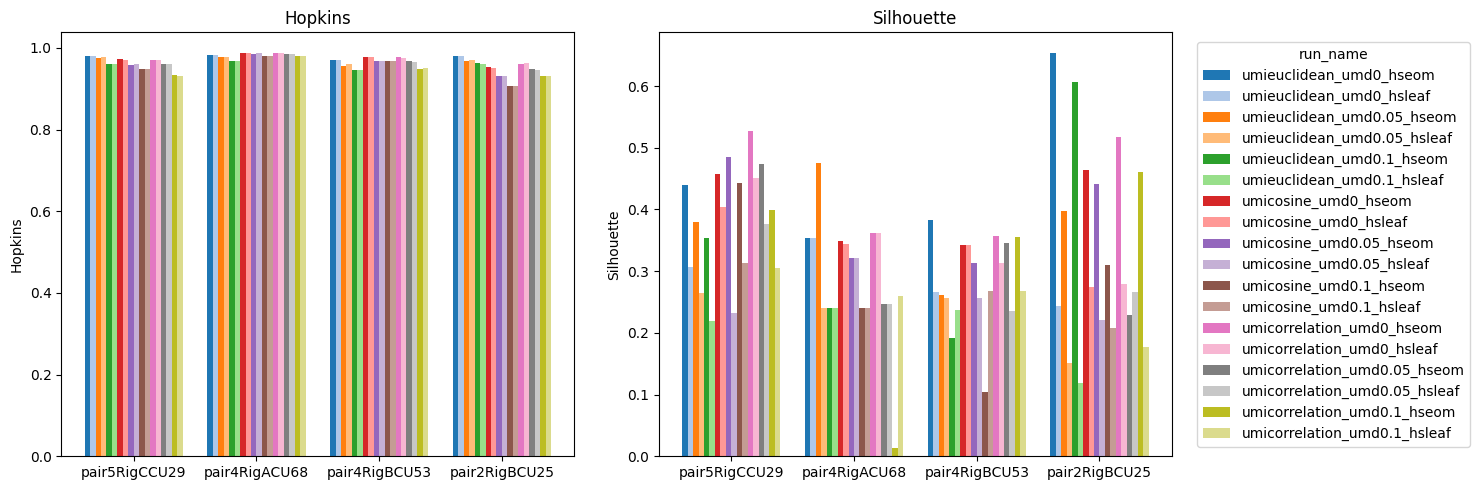

In [18]:
bird_ids = birdIDs
cmap = plt.get_cmap('tab20')
col_list = [cmap(i) for i in range(len(run_names))]
run_name_to_color = {run: col_list[i] for i, run in enumerate(run_names)}

# Setup
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 0.3]})
metrics_to_plot = ['hopkins', 'silhouette']
width = 0.8 / len(run_names)
x = np.arange(len(bird_ids))

# Plot loop
for ax, metric in zip(axes[:2], metrics_to_plot):
    for i, run in enumerate(run_names):
        vals = [
            metrics.loc[(metrics['birdID'] == bird) & (metrics['run_name'] == run), metric].values[0]
            if not metrics[(metrics['birdID'] == bird) & (metrics['run_name'] == run)].empty else np.nan
            for bird in bird_ids
        ]
        ax.bar(x + i * width, vals, width, label=run, color=run_name_to_color[run])
    ax.set_title(metric.capitalize())
    ax.set_xticks(x + width * (len(run_names) - 1) / 2)
    ax.set_xticklabels(bird_ids)
    ax.set_ylabel(metric.capitalize())

# Legend in third panel
axes[2].axis('off')  # Hide axis
handles, labels = axes[0].get_legend_handles_labels()
axes[2].legend(handles, labels, title='run_name', loc='center')

plt.tight_layout()
plt.show()

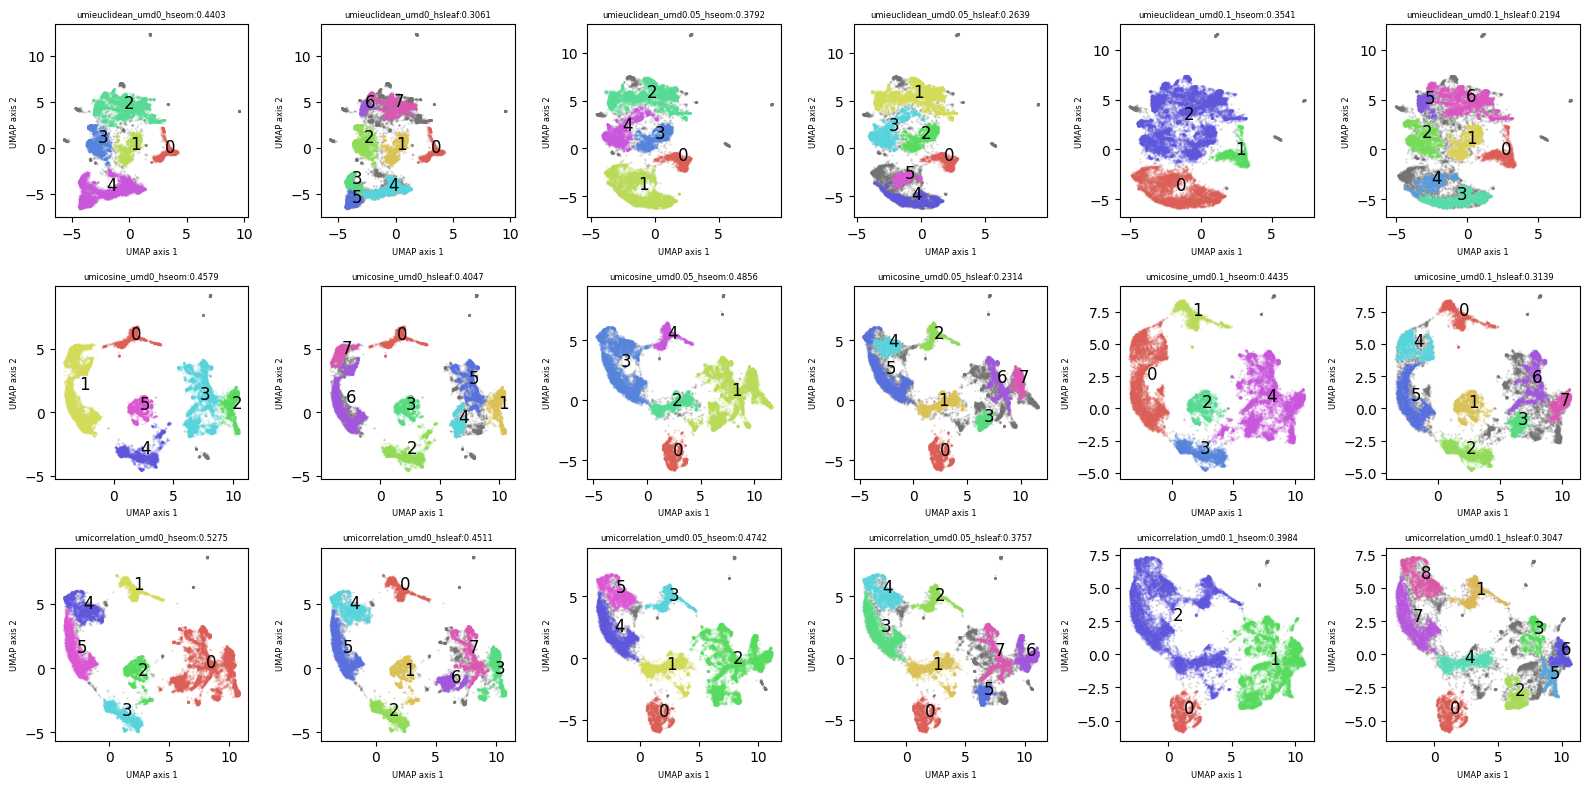

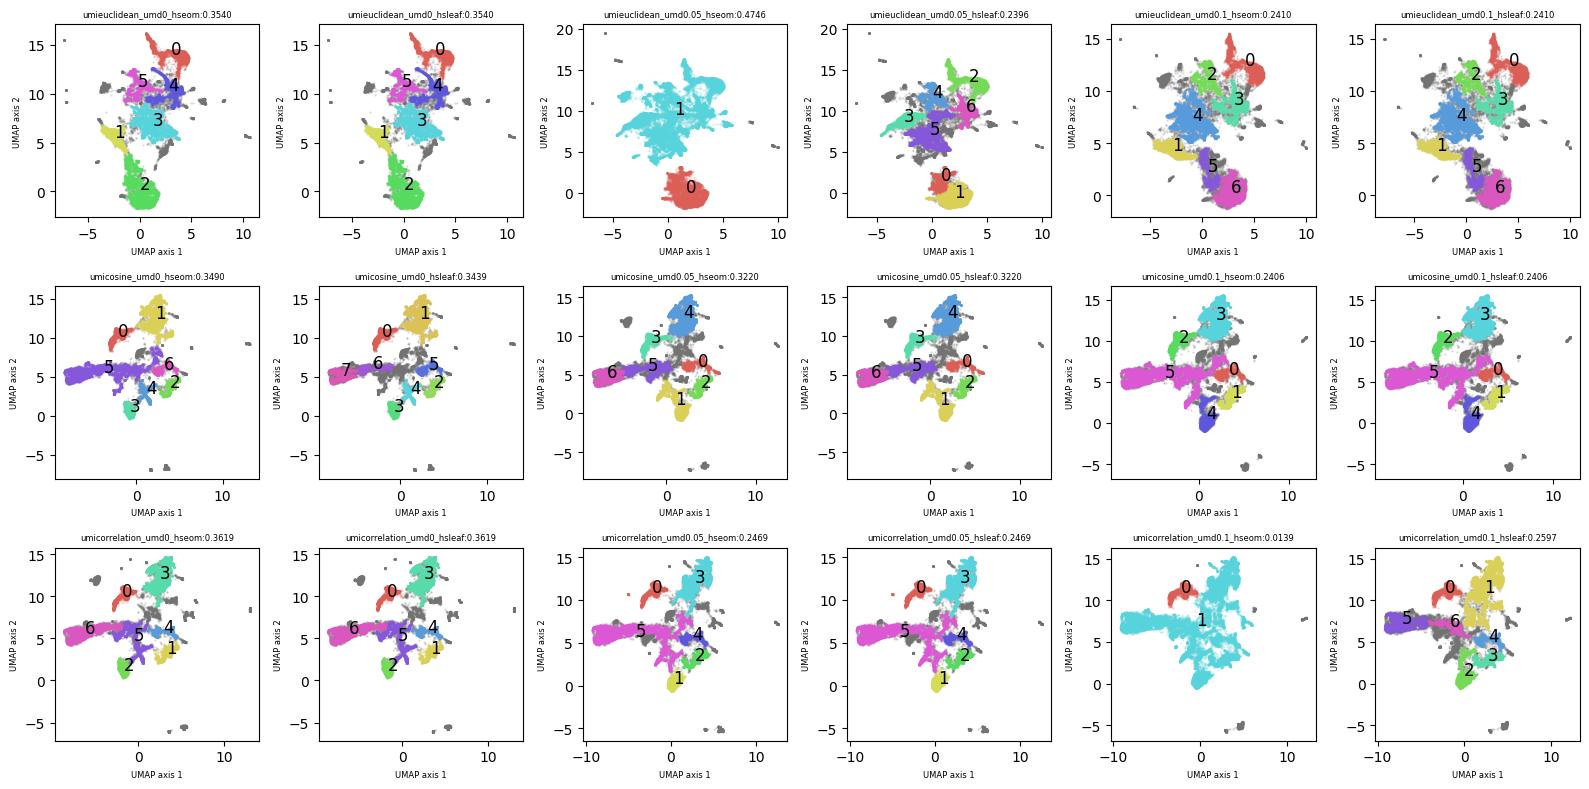

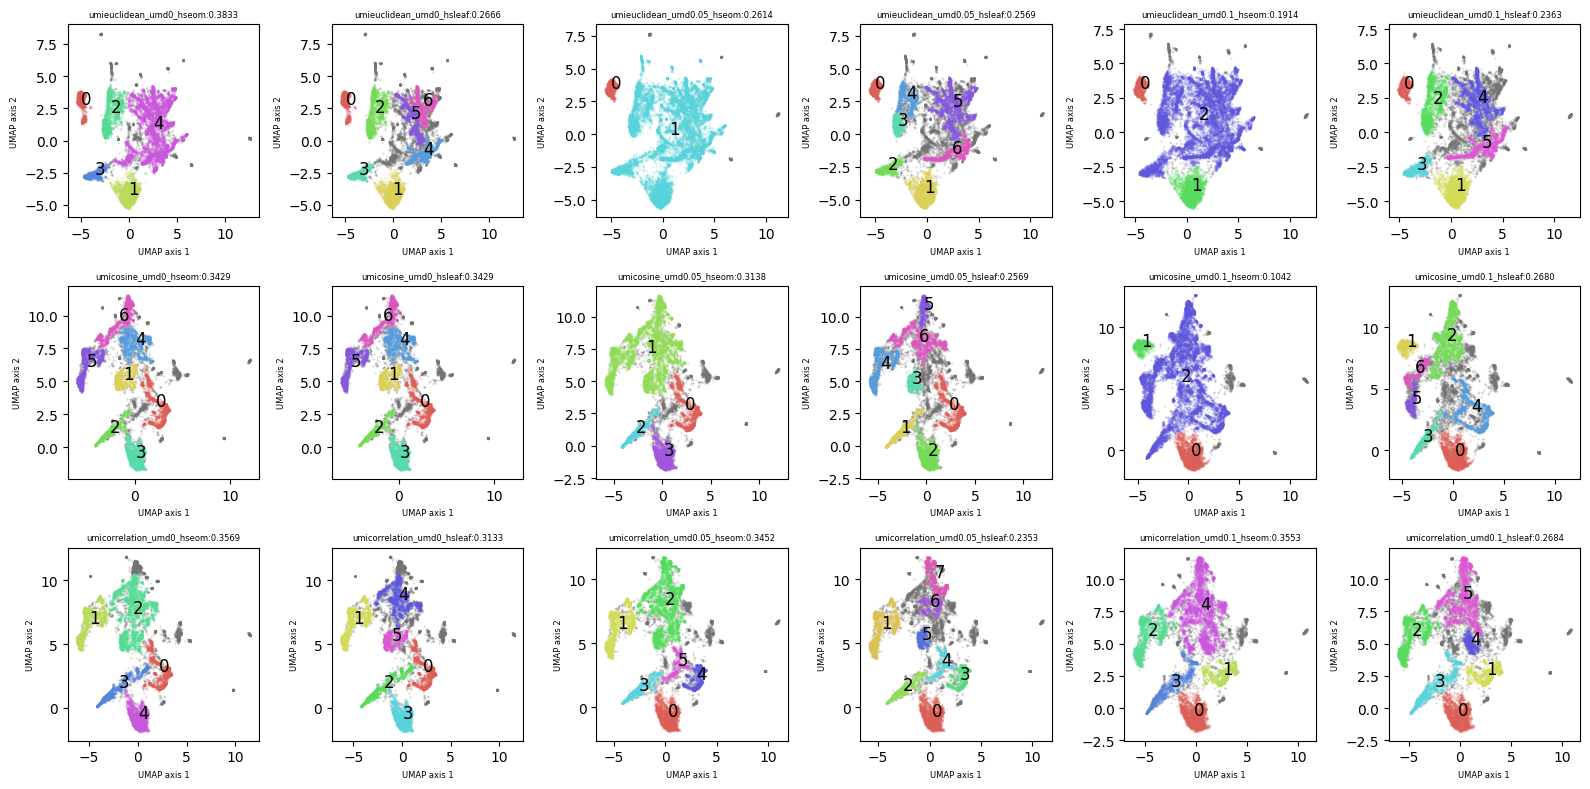

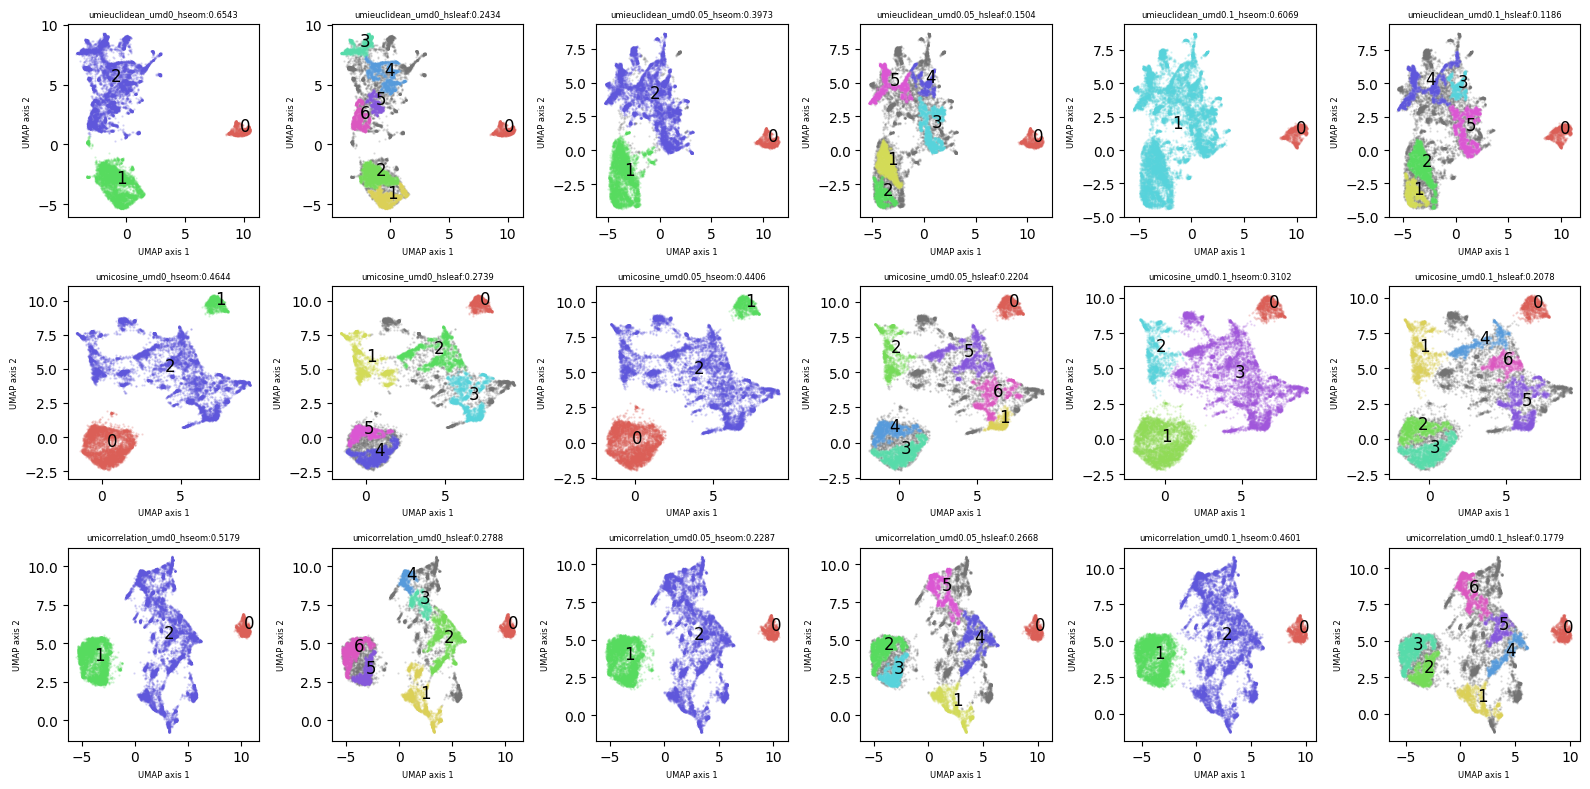

In [22]:
# Combine the HDBSCAN clustering plot
# bi = 0
for bi in range(len(birdIDs)):
    bd = birdIDs[bi]
    # one figure for each bird
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=[16, 8])

    for ri in range(len(run_names)):
        rn = run_names[ri]
        fd_save = os.path.join(fd_data, bd, 'UMAPonSpec3', sylStr)
        fn_embed = os.path.join(fd_save, f'{bd}.UMAPonSpec.{rn}.embedding.csv')
        embed = pd.read_csv(fn_embed, index_col=0)

        plot_i = ri//6
        plot_j = ri%6
        ax = axes[plot_i][plot_j]
        # color calls according to hdbscan labels
        col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster'])+1)
        # plot embedding
        for hi in range(-1, max(embed['hdbscan_cluster'])+1):
            embed_s = embed[embed['hdbscan_cluster']==hi]
            if hi==-1:
                ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
            else:
                ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color=col_long[hi])
                # add syl label
                ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
        sil = metrics.loc[(metrics['birdID'] == bd) & (metrics['run_name'] == rn), 'silhouette'].iloc[0]
        ax.set_title(f'{rn}:{sil:.4f}', fontsize=6)
        ax.set_xlabel('UMAP axis 1', fontsize=6)
        ax.set_ylabel('UMAP axis 2', fontsize=6)
    plt.tight_layout()
    # save plot
    fn_fig = os.path.join(fd_save, f'{bd}.HDBSCANcomb.pdf')
    fig.savefig(fn_fig)

### how many calls in total per bird?

In [23]:
for bi in range(len(birdIDs)):
    bd = birdIDs[bi]
    rn = run_names[0]
    fd_save = os.path.join(fd_data, bd, 'UMAPonSpec2', sylStr)
    fn_embed = os.path.join(fd_save, f'{bd}.UMAPonSpec.{rn}.embedding.csv')
    embed = pd.read_csv(fn_embed, index_col=0)
    print(f'{bd}: {embed.shape[0]}')

pair5RigCCU29: 23240
pair4RigACU68: 36359
pair4RigBCU53: 16194
pair2RigBCU25: 16452
